# Convolutional Neural Network with legacy TF

In [1]:
!rm -rf ./graphs/

In [ ]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm, trange
print(tf.__version__)

In [ ]:
tf.set_random_seed(2)

In [ ]:
(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32)
x_test = (x_test/255).astype(np.float32)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

In [ ]:
# Declare Input Node
x = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28])
y = tf.placeholder(dtype=tf.int32, shape=[None])

x_reshape = tf.reshape(x, [-1, 28, 28, 1])
# Declare parameter
W_conv1 = tf.Variable(initial_value=tf.truncated_normal([5, 5, 1, 20]) , dtype=tf.float32)
b_conv1 = tf.Variable(initial_value=tf.zeros([20]))

W_conv2 = tf.Variable(initial_value=tf.truncated_normal([5, 5, 20, 50]) , dtype=tf.float32)
b_conv2 = tf.Variable(initial_value=tf.zeros([50]))

W_fc1 = tf.Variable(initial_value=tf.truncated_normal([50*7*7, 500]) , dtype=tf.float32)
W_fc2 = tf.Variable(initial_value=tf.truncated_normal([500, 10]) , dtype=tf.float32)

# graph
conv1 = tf.nn.conv2d(x_reshape, W_conv1, strides=[1, 1, 1, 1], padding="SAME") + b_conv1
h1 = tf.nn.tanh(conv1)
pool1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

conv2 = tf.nn.conv2d(pool1, W_conv2, strides=[1, 1, 1, 1], padding="SAME") + b_conv2
h2 = tf.nn.tanh(conv2)
pool2 = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

# flatten
pool2_flat = tf.reshape(pool2, [-1, 50*7*7])

fc1 = tf.matmul(pool2_flat, W_fc1)
h1_fc1 = tf.nn.tanh(fc1)

score = tf.matmul(h1_fc1, W_fc2)

prediction = tf.argmax(input = score, axis=1)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=score)

In [ ]:
opt = tf.train.GradientDescentOptimizer(0.01)
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = opt.minimize(loss, global_step = global_step)

# TensorBoard
softmaxLoss = tf.summary.scalar(name='softmax_loss', tensor=loss)
train_writer = tf.summary.FileWriter('./graphs/low-level/train_mnist_dnn', graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter('./graphs/low-level/val_mnist_dnn', graph=tf.get_default_graph())

In [ ]:
# Hyper Parameter
epoch = 100
total_bar_length = tqdm_notebook(range(epoch))
batch_size=512
total_step = int(x_train.shape[0] / batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_loss_hist = []
val_loss_hist = []

for i in total_bar_length:
    avg_train_loss = 0   
    avg_val_loss = 0 
    
    val_loss = 0
    
    train_loss_sum = 0    
    val_loss_sum = 0
    
    for step in range(total_step):
            batch_indices = np.random.choice(range(x_train.shape[0]), size=batch_size, replace=False)

            batch_xs = x_train[batch_indices]
            batch_ys = y_train[batch_indices]
            
            val_indices = np.random.choice(range(x_val.shape[0]), size=batch_size, replace=False)
            
            val_xs = x_val[val_indices]
            val_ys = y_val[val_indices]

            _, train_loss = sess.run([optimizer, loss], feed_dict={x:batch_xs, y:batch_ys})
            
            val_loss = sess.run(fetches = loss, feed_dict={x:val_xs, y:val_ys})
            
            avg_train_loss += train_loss / total_step
            avg_val_loss += val_loss / total_step
        
    train_loss_hist.append(avg_train_loss)
    val_loss_hist.append(val_loss)
    
    train_loss_sum = sess.run(softmaxLoss, feed_dict={x:batch_xs, y:batch_ys})
    val_loss_sum = sess.run(fetches = softmaxLoss, feed_dict={x:val_xs, y:val_ys})

    train_writer.add_summary(train_loss_sum, global_step = i)
    val_writer.add_summary(val_loss_sum, global_step = i)
        
train_writer.close()
val_writer.close()

print("train finished")

In [ ]:
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist, label="validation")
plt.legend()
plt.show()

In [ ]:
yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

# <span style="color:red">!!Kernel Restart!! </span>

# Convolutional Neural Network Using Keras + Eager Execution

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow import keras
from tqdm import tqdm_notebook, tqdm, trange
%matplotlib inline
tf.enable_eager_execution()
print(tf.__version__)

1.12.0


In [2]:
(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32)
x_test = (x_test/255).astype(np.float32)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

x_train = x_train.reshape((-1, 28, 28, 1))
x_val = x_val.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [3]:
class CNNClassifier(keras.Model):
    def __init__(self, num_classes=10):
        super(CNNClassifier, self).__init__()
        self._layer1 = keras.layers.Conv2D(64, (5, 5), padding='same', strides=(2, 2), activation='relu',
                                                kernel_initializer='he_normal')
        self._layer2 = keras.layers.MaxPool2D()
        self._layer3 = keras.layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu',
                                                kernel_initializer='he_normal')
        
        self._layer4 = keras.layers.GlobalAveragePooling2D()                
        self._layer5 = keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        out = self._layer1(inputs)
        out = self._layer2(out)
        out = self._layer3(out)
        out = self._layer4(out)
        out = self._layer5(out)
        return out

In [4]:
# Loss function
def loss_fn(model, x, y):
    logits = model(x)
    y = tf.dtypes.cast(y, tf.int32)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

In [5]:
# Hyper Parameters
epoch = 100
batch_size = 100
learning_rate = 0.005
total_step = int(x_train.shape[0] / batch_size)

In [6]:
# train
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

# validation
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=10000)
val_dataset = val_dataset.batch(batch_size=batch_size)
print(val_dataset)

# test
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=10000)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.uint8)>


In [7]:
global_step = tf.train.get_or_create_global_step()

# creating optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

# create writer for tensorboard
summary_writer = tf.contrib.summary.create_file_writer(logdir='./graphs/keras_eager/')

In [8]:
mnist = CNNClassifier()

In [9]:
# training
train_loss_hist = []
val_loss_hist = []

total_bar_length = tqdm_notebook(range(epoch))

device = '\cpu:0' if tfe.num_gpus() == 0 else 'gpu:0'

with tf.device(device):
    for i in total_bar_length:

        avg_train_loss = 0
        avg_val_loss = 0
        train_step = 0
        val_step = 0

        # training
        with summary_writer.as_default(), tf.contrib.summary.always_record_summaries():
            for x, y in train_dataset:
                with tf.GradientTape() as tape:
                    train_loss = loss_fn(mnist, x, y)
                grads = tape.gradient(target=train_loss, sources=mnist.variables)
                opt.apply_gradients(grads_and_vars=zip(grads, mnist.variables), global_step=global_step)
                tf.contrib.summary.scalar(name='train_loss', tensor=train_loss)
                avg_train_loss += train_loss
                train_step += 1
            else:
                avg_train_loss /= train_step
                train_loss_hist.append(avg_train_loss)

            # validation
            for _x, _y in val_dataset:
                val_loss = loss_fn(mnist, _x, _y)
                tf.contrib.summary.scalar(name='val_loss', tensor=val_loss)
                avg_val_loss += val_loss
                val_step += 1
            else:
                avg_val_loss /= val_step
                val_loss_hist.append(avg_val_loss)

        if (i + 1) % 10 == 0:
            print("epoch : {:3}, train_loss : {:.2f}, val_loss : {:.2f}".format(i, avg_train_loss, avg_val_loss))

epoch :   9, train_loss : 2.25, val_loss : 2.25
epoch :  19, train_loss : 2.08, val_loss : 2.08
epoch :  29, train_loss : 2.03, val_loss : 2.03
epoch :  39, train_loss : 2.01, val_loss : 2.01
epoch :  49, train_loss : 2.00, val_loss : 2.00
epoch :  59, train_loss : 1.99, val_loss : 1.99
epoch :  69, train_loss : 1.99, val_loss : 1.99
epoch :  79, train_loss : 1.98, val_loss : 1.98
epoch :  89, train_loss : 1.98, val_loss : 1.98
epoch :  99, train_loss : 1.97, val_loss : 1.98



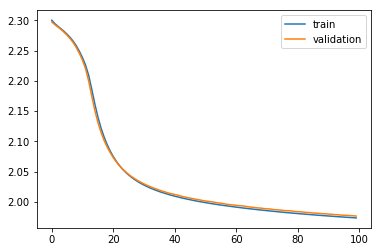

In [10]:
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist, label="validation")
plt.legend()
plt.show()

In [11]:
scores = list()
yhat = list()
for __x, __y in test_dataset:
    out = mnist.call(__x)
    score = np.argmax(out, axis=1)
    
    scores.extend(score.tolist())
    yhat.extend(__y.numpy().tolist())

scores = np.asarray(scores)
yhat = np.asarray(yhat)

print("acc : {:.2%}".format(np.mean(yhat == scores)))

acc : 51.40%
